In [1]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import artm

path_vw = "../VK/batches_w10d3W152win10/merged.txt"
#path_batches = "../VK/bigartm_w10d3W152win10" # основная папка с батчами

path_batches = "../VK/bigartm_1" # первая часть батчей
path_batches_2 = "../VK/bigartm_2" # вторая часть батчей

# первый батч_векторайзер
batch_vectorizer = None
if len(glob.glob(path_batches + "/*.batch")) < 1:
    batch_vectorizer = artm.BatchVectorizer(data_path=path_vw, 
                                            data_format='vowpal_wabbit', batch_size = 1000, 
                                            target_folder=path_batches)
else:
    batch_vectorizer = artm.BatchVectorizer(data_path=path_batches, data_format='batches')
    
# второй батч_векторайзер    
batch_vectorizer_2 = None
if len(glob.glob(path_batches + "/*.batch")) < 1:
    batch_vectorizer_2 = artm.BatchVectorizer(data_path=path_vw, 
                                            data_format='vowpal_wabbit', batch_size = 1000, 
                                            target_folder=path_batches)
else:
    batch_vectorizer_2 = artm.BatchVectorizer(data_path=path_batches_2, data_format='batches')

In [2]:
all_topics = []
for i in range(0, 400):
    topic_name = "topic" + str(i)
    all_topics.append(topic_name)

def prepare(model):
    # беру словарь, собранный ранее по основной папке с батчами и лежаший в ней
    path_batches = "../VK/bigartm_w10d3W152win10"
    model.load_dictionary(dictionary_name='cooc_dictionary', 
                          dictionary_path=path_batches + '/cooc_dictionary.dict')
    model.initialize(dictionary_name='cooc_dictionary')
    
    model.scores.add(artm.PerplexityScore(name='Perplexity',
                                      use_unigram_document_model=False,
                                      dictionary_name='cooc_dictionary'))

    model.scores.add(artm.SparsityPhiScore(name='SparsityPhi'))

    model.scores.add(artm.SparsityThetaScore(name='SparsityTheta'))

    model.scores.add(artm.TopTokensScore(name='Top100Tokens', 
                                         num_tokens=100, 
                                         dictionary_name = 'cooc_dictionary'))

    model.scores.add(artm.TopicKernelScore(name='TopicKernel', 
                                           probability_mass_threshold=0.25, 
                                           dictionary_name = 'cooc_dictionary'))

def figures(model):
    # convergence
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots()
    ax1.plot(x, model.score_tracker['Perplexity'].value[1:], 'g-', linewidth=2, label="Perplexity")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Perplexity', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['SparsityPhi'].value[1:], 'r*', linewidth=2, label="Phi sparsity")
    ax2.plot(x, model.score_tracker['SparsityTheta'].value[1:], 'r--', linewidth=2, label="Theta sparsity")
    #ax2.plot(x, model.score_tracker['BackgroundMassScore'].value[1:], 'r^', linewidth=2, label="Background ratio")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()
    
    # interpretability
    x = range(model.num_phi_updates)[1:]
    fig, ax1 = plt.subplots()
    ax1.plot(x, model.score_tracker['Top100Tokens'].average_coherence[1:], 'g-', linewidth=2, label="size")
    ax1.set_xlabel('Iterations count')
    ax1.set_ylabel('Coherence top100-win5', color='g')
    ax2 = ax1.twinx()
    ax2.plot(x, model.score_tracker['TopicKernel'].average_contrast[1:], 'r*', linewidth=2, label="contrast")
    ax2.plot(x, model.score_tracker['TopicKernel'].average_purity[1:], 'r--', linewidth=2, label="purity")
    ax2.set_ylabel('Ratio', color='r')
    ax2.legend(bbox_to_anchor=(1.10, 1), loc=2, borderaxespad=0.)
    plt.grid(True)
    plt.show()

In [3]:
import time
start_time = time.time()

model = artm.ARTM(topic_names = all_topics, cache_theta=False, reuse_theta=False, num_document_passes=10)
prepare(model)

print 'Elapsed time: {} sec.'.format(time.time() - start_time)

Elapsed time: 52.269269228 sec.


Elapsed time: 1153.32514715 sec.
Perplexity final: 5653.03470875


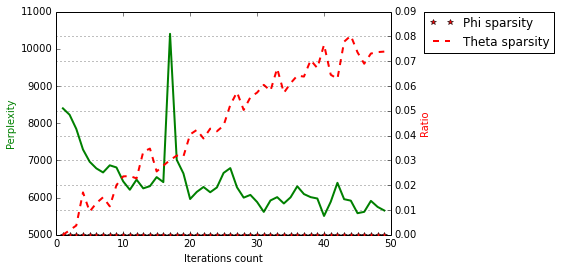

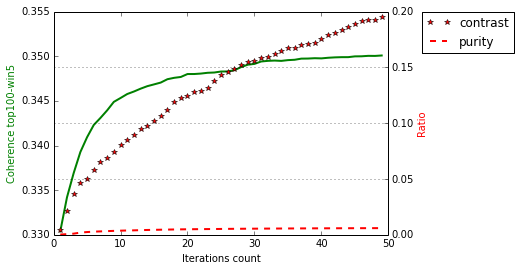

In [4]:
import time
start_time = time.time()

model.fit_online(batch_vectorizer=batch_vectorizer, update_every=3)
model.fit_online(batch_vectorizer=batch_vectorizer_2, update_every=3)

print 'Elapsed time: {} sec.'.format(time.time() - start_time)
print 'Perplexity final: {}'.format(model.score_tracker['Perplexity'].value[-1])
figures(model)

Elapsed time: 1214.83580804 sec.
Perplexity final: 4110.6772699


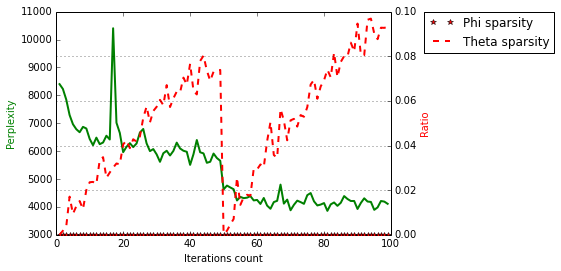

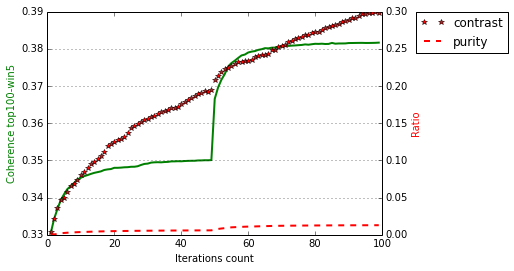

In [5]:
import time
start_time = time.time()

model.fit_online(batch_vectorizer=batch_vectorizer, update_every=3)
model.fit_online(batch_vectorizer=batch_vectorizer_2, update_every=3)

print 'Elapsed time: {} sec.'.format(time.time() - start_time)
print 'Perplexity final: {}'.format(model.score_tracker['Perplexity'].value[-1])
figures(model)